# Overview of LASSO-ShCu Data for Southern Great Plains

The LASSO Shallow-Convection scenario focuses on shallow convective clouds at the Southern Great Plains (SGP) atmospheric obesrvatory in Oklahoma. Ensembles of idealized large-eddy simulation (LES) runs are available for 95 case dates spanning the years 2015-2019.

Useful links for more information:
* [LASSO Overview Website](https://www.arm.gov/capabilities/modeling/lasso/)
* [LASSO Overview Paper, Gustafson et al. (BAMS, 2020)](https://doi.org/10.1175/BAMS-D-19-0065.1)
* [LASSO-Shcu Technical Document](www.arm.gov/publications/tech_reports/doe-sc-arm-tr-216.pdf)
* [LASSO-ShCu Bundle Browser](https://adc.arm.gov/lassobrowser)

**Author:** William.Gustafson@pnnl.gov  
**Date:** 8-May-2024

In [13]:
# Libraries required for this tutorial...

# import dask
from datetime import datetime
import numpy as np
import xarray as xr
import xwrf

import matplotlib.pyplot as plt

## Avaialble LASSO-ShCu Datastreams

LASSO-ShCu consists of a suite of datastreams that combine a library of LES simulations with ARM observations to put the simulations in the context of reality for each case date. The following datastreams can be downloaded from the :

1. **sgplassodiagconfobsmod:** Config-Obs-Model
    * Input data necessary to reproduce a simulation
    * Skill score information and plots summarizing model results for each simulation in the case date's ensemble, typically hourly resolution
2. **sgplassodiagraw:** Raw Model Output
    * `wrfout` hourly files containing instantaenous model snapshots every 10 minutes
    * `wrfstat` files containing LES statistics every 10 minutes, e.g., output-period-averaged domain-mean profiles
3. **sgplassocogsdiagobsmod:** Clouds Optically Gridded by Stereo (COGS)-based skill analysis; when avaialble (only 2018-2019), this is considered more reliable than the ARSCL-based skill-scores for cloud fraction in `sgplassodiagconfobsmod`
    * 1-minute and 10-minute sampled cloud fraction obserations using COGS
    * Overview cloud-fraction skill-score values and plots for the simulation ensemble for the selected case date
    * Simulation-specific cloud-fraction skill-score information for each simulation on the selected case date
4. **sgplassohighfreqobs:** High-frequency observations that were used to build `sgplassodiagconfobsmod`
    * **sgp915rwpwindcon10mC1.c1:** Wind profiles retrieved from radar-wind profilers at C1, I8, I9, and I10, 10-minute intervals
    * **sgpcldfracset*C1.c1:** KAZR-ARSCL derived time-height cloud fraction profiles for 1, 5, and 15-minute intervals
    * **sgplassoblthermoC1.c1:** Boundary-layer thermodynamic information for 500-700 m above surface from AERIoe and Raman lidar retrievals; temperature, water vapor mixing ratio, relative humidity, and pressure on 10-minute interval
    * **sgplassodlcbhshcu\*.c1:** cloud-base height from Doppler lidar at stations C1, E32, E37, E39, and E41
    * **sgplassolwpC1.c1:** Liquid water path retrieved from AERI and MWRRET
    * **sgplclC1.c1:** Lifting condensation level for meteorology stations in the Oklahoma region


## Downloading and Organizing the Datastreams

All of the above datastreams can be downloaded from the [LASSO-ShCu bundle Browser](https://adc.arm.gov/lassobrowser). The table at the bottom of that webpage updates based on selections made in the checkboxes along the lefthand side of the page. Then, one selects which simulations and associated files are desired within the table. When all selections have been made, the `Order Data` button is at the bottom of the page. Users will have the most reliable download experience by also turning on the Globus option within `Download Options`. Most of the datastreams are managemable, with the exception of `sgplassodiagraw`, which can be a bit large for some users to work with--that one can crash FTP downloads via html and Globus gets around this issue.

Some datastreams contain files just for one simulation, while others have multiple simulation worth of information. So, the folder structures within the datastreams varies. An easy way to organize the data is in a tree structure by case date and simulation ID. This can be done by placing downloaded tar files into a single folder and then running `support_code/stage_lasso_shcu_data.py` that is in this tutorial's sub-folder.

The remainder of this notebook assumes one is working with data organized using `stage_lasso_shcu_data.py`.

## Raw WRF Output from LASSO-ShCu

The core of LASSO-ShCu is raw simulation output from the Weather Research and Forecasting (WRF) model, which has been run in an idealized LES mode with doubly periodic boundaries. The traditional `wrfout` file from WRF is provided to the users as-is. The bulk of the variables within the file are as one would expect from WRF. Additionaly, some LES-specific information is output, such as the forcing tendencies. LES modelers frequently work with summary statistics instead of cell-by-cell data, so we also output a `wrfstat` file that provides 10-minute averages for various metorology variables and diagnostics. Diagnostics include variables like cloud and ice water paths, domain-averaged profiles, fluxes, and in-cloud statistics.

Let's take a look at a `wrfstat` file first since these are smaller and easier to work with.

In [14]:
# Plotting wrfstat variables...

path_shcu_root = "/gpfs/wolf2/arm/atm124/world-shared/arm-summer-school-2024/lasso_tutorial/ShCu/untar/"

case_date = datetime(2019, 4, 4)
sim_id = 4

ds_stat = xr.open_dataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfstat_d01_{case_date:%Y-%m-%d_12:00:00}.nc")
ds_stat

<xarray.Dataset> Size: 72GB
Dimensions:         (Time: 91, bottom_top: 226, bottom_top_stag: 227,
                     south_north: 250, west_east: 250, west_east_stag: 251,
                     south_north_stag: 251)
Coordinates:
    XTIME           (Time) datetime64[ns] 728B ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north,
                                west_east, west_east_stag, south_north_stag
Data variables: (12/179)
    Times           (Time) |S19 2kB ...
    CST_CLDLOW      (Time) float32 364B ...
    CST_CLDTOT      (Time) float32 364B ...
    CST_LWP         (Time) float32 364B ...
    CST_IWP         (Time) float32 364B ...
    CST_PRECW       (Time) float32 364B ...
    ...              ...
    CSV_IWC         (Time, bottom_top, south_north, west_east) float32 5GB ...
    CSV_CLDFRAC     (Time, bottom_top, south_north, west_east) float32 5GB ...
    CSS_LWP         (Time, south_north, west_east) float32 23MB ...
    CSS_IWP         (Time, south_north, west_east) float32 23MB ...
    CSS_CLDTOT      (Time, south_north, west_east) float32 23MB ...
    CSS_CLDLOW      (Time, south_north, west_east) float32 23MB ...
Attributes: (12/96)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

Notice that there are several categories of variable names:

1. `CST` are time series wher all the spatial dimensions have been collapsed via averaging or vertical integration. An example is `CST_LWP` for domain-average liquid water path.
2. `CSP` are time series of profiles. The X-Y dimensions have been collapsed via averaging but vertical information is retained. The variable related to `CST_LWP`is `CSP_LWC` for the domain-averaged liquid water content profile.
3. `CSS` are time series of X-Y slices. Continuing on the theme of quantifying the condensate, `CSS_LWP` is the liquid water path with X-Y information retained.
4. `CSV` are full-volume variables with X-Y-Z-T dimensions. A condensate example would be `CSV_QR` for the rainwater mixing ratio. This is similar to the `QRAIN` variable output normally by WRF. However, the variables in `wrfstat` are averaged between output times, where as variables in the `wrfout` files are instantaneous.

Plotting `wrfstat` data is straightforward since all output times from a run are included in one file.

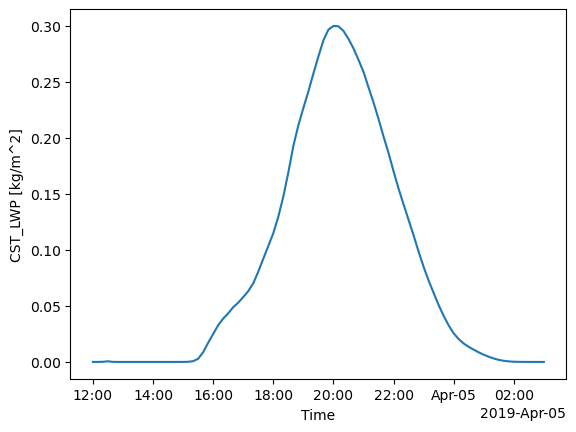

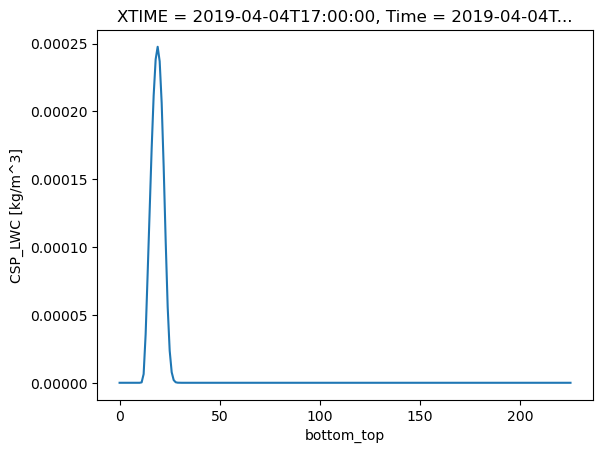

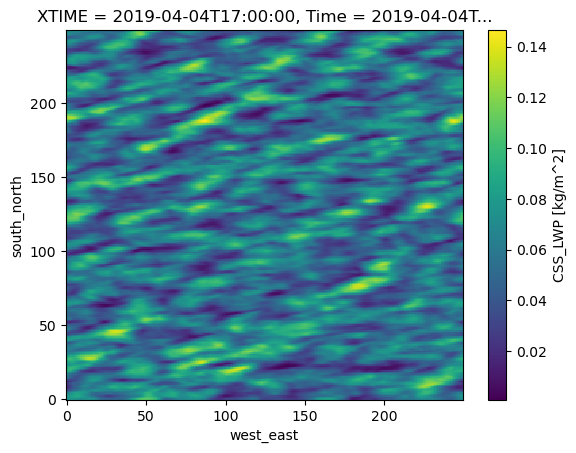

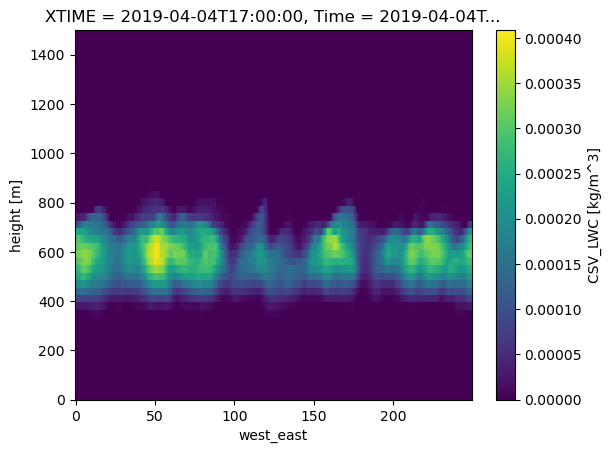

In [15]:
# By default, xarray does not interpret the wrfout/wrfstat time information in a way that attaches 
# it to each variable. Here is at trick to map the time held in XTIME with the Time coordinate 
# associated with each variable.
ds_stat["Time"] = ds_stat["XTIME"]

# Now that we fixed the time coordinate, we can use xarray's plotting features to get time-labeled plots.

hour_to_plot = 17

# Time series:
ds_stat["CST_LWP"].plot()
plt.show()

# Profile at a selected time (plots sideways, though, since we are being lazy):
ds_stat["CSP_LWC"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()
plt.show()

# X-Y slice for a selected time:
ds_stat["CSS_LWP"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()
plt.show()

# A vertical slice from the volume at a selected time:
# We'll assign the vertical coordinate values for this one and hide the cloud-free upper atmosphere.
plot_data = ds_stat["CSV_LWC"].assign_coords(height=(ds_stat["CSP_Z"]))
plot_data.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00", south_north=1).plot(y="height", ylim=[0, 1500])
plt.show()

This is a good point to check out part 2 of the LASSO-ShCu tutorial, [lasso-shcu_part2.ipynb](./lasso-shcu_part2.ipynb). That shows how to do a 3-D isosurface plot of the LWC data. We isolate that in a separate notebook since the resulting file gets large and can cause rendring issues in some situations. Come back and continue here after looking at the part2 notebook.

In addition to the `wrfstat` file, the `sgplassodiagraw` dataset includes the instantaneous `wrfout` files, which contain one output time per `wrfout`. These files are essentially traditional WRF model output and can be read using one the WRF tools that exist in the wild such as [xWRF](https://xwrf.readthedocs.io/en/latest/) or [wrf-python](https://wrf-python.readthedocs.io/en/latest/index.html). One can also hand-code the data parsing based on the level of detail needed for a particular application. This can be faster than using the more all-encompasing tools. See the [xWRF tutorial](../xarray/xwrf-xarray-intro.ipynb) for an example of using xWRF.

In [16]:
# Open a wrfout time series using a manual approach...

case_date = datetime(2019, 4, 4)
sim_id = 4

# Note the extra details required by open_mfdataset to connect the files together in time.
ds_wrf = xr.open_mfdataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfout_d01_*.nc", 
                           combine="nested", concat_dim="Time")

ds_wrf["Time"] = ds_wrf["XTIME"]  # Fix the time coordinate like we did for the wrfstat file

Let's plot a time series of downwelling shortwave radiation.

Since all columns are statistically identical in this idealized model configuration, let's plot the corner column and compare to a domain average.


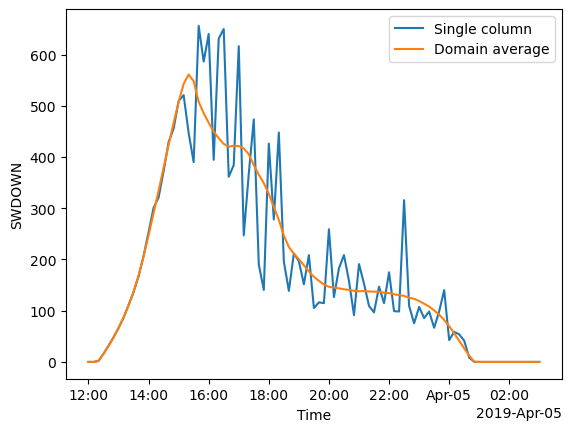

In [17]:
fig, ax = plt.subplots(ncols=1)

ds_wrf["SWDOWN"].isel(west_east=0, south_north=0).plot(ax=ax, label="Single column")
ds_wrf["SWDOWN"].mean(dim=["west_east", "south_north"]).plot(ax=ax, label="Domain average")
ax.legend()

plt.show()

WRF uses an Arakawa C grid, which means the winds and height information are on cell edges, while the rest of the information is stored on the cell centers. Manually destaggering variables is where the approach of hand-coding the WRF processing becomes a bit annoying. Here is a quick example for the winds.  U and V wind components are staggered in the X and Y directions, respectively. The height information is staggered in the vertical, but we will not deal with that in this notebook.

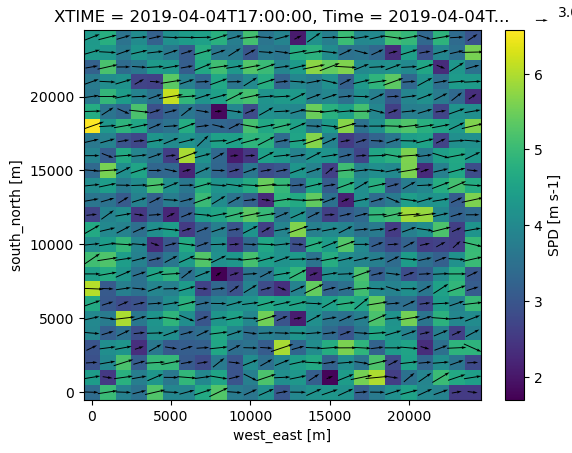

In [18]:
# Plot wind vectors at a selected level to demonstrate how to destagger the wind components to cell-center values with xarray...

plot_level = 12  # index of level to plot
skip_xy = 10  # Sampling interval for the vector thinning

nt, nz, ny, nx = ds_wrf["T"].shape

# We need to:
# 1) destagger to cell centers
# 2) rename the staggered dimension back to the non-staggered name to avoid dimension conflicts
# 3) (re)name the unstaggered wind for convenience
# Then, we are able to put these new DataArrays back into the ds_wrf Dataset.

ds_wrf["UA"] = 0.5*( ds_wrf["U"].isel(west_east_stag=slice(0, nx)) + 
                    ds_wrf["U"].shift(west_east_stag=-1).isel(west_east_stag=slice(0, nx)) ).\
                    rename("UA").rename(west_east_stag="west_east")
ds_wrf["VA"] = 0.5*( ds_wrf["V"].isel(south_north_stag=slice(0, ny)) + 
                    ds_wrf["V"].shift(south_north_stag=-1).isel(south_north_stag=slice(0, ny)) ).\
                    rename("VA").rename(south_north_stag="south_north")
ds_wrf["SPD"] = np.sqrt(ds_wrf["UA"]**2 + ds_wrf["VA"]**2).rename("wind speed").\
                    assign_attrs(units="m s-1", description="wind speed")

# Now, we can proceed to more plotting-specific data manipulation. We need to
# add spatial variables for the idealized domain (since XLAT and XLONG are
# constant in the file). This is needed by the xarray quiver routine.
# Then, thin the grid to reduce the number of arrrows.
ds_wrf["west_east"] = xr.DataArray(data=np.arange(nx)*ds_wrf.attrs["DX"], dims="west_east", name="west_east", attrs={"units": "m"})
ds_wrf["south_north"] = xr.DataArray(data=np.arange(ny)*ds_wrf.attrs["DX"], dims="south_north", name="south_north", attrs={"units": "m"})

ds_wrf_thinned = ds_wrf.\
    isel(west_east=slice(0, nx, skip_xy), south_north=slice(0, ny, skip_xy), bottom_top=plot_level).\
    sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")

fig, ax = plt.subplots(ncols=1)
ds_wrf_thinned["SPD"].plot(ax=ax, x="west_east", y="south_north")
ds_wrf_thinned.plot.quiver(ax=ax, x="west_east", y="south_north", u="UA", v="VA",
                           scale=100)
plt.show()


Next, let's reproduce the above plot using xWRF to see how this is simpler. After opening the wrfout files with xWRF, note the extra variables added at the end of the variable list for `wind_east` and `wind_north`. These are the destaggered winds rotated to earth-relative directions. The rotation matters for map projections, but not for idealized runs like we have here. The other thing to note is that the west_east, south_north, and bottom_top coordinates are replaced by x, y, and z with proper units.

In [19]:
# Option 2 using xWRF... 
# NOTE: requires xWRF >=0.0.4 to handle the idealized wrfout file from LASSO-ShCu

# Note the special arguments sent to open_mfdataset to piece together the files along the time dimension.
# Then, there is the extra xwrf postprocessing command on the end to destagger and set up coordinates.
ds_xwrf = xr.open_mfdataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfout_d01_*.nc", combine="nested", concat_dim="Time").xwrf.postprocess()
ds_xwrf

<xarray.Dataset> Size: 255GB
Dimensions:                    (Time: 91, y: 250, x: 250, soil_layers_stag: 5,
                                z: 226, x_stag: 251, y_stag: 251, z_stag: 227,
                                force_layers: 751)
Coordinates: (12/15)
    XLAT                       (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XLONG                      (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 728B dask.array<chunksize=(6,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 251kB dask.array<chunksize=(125, 126), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 251kB dask.array<chunksize=(125, 126), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 251kB dask.array<chunksize=(126, 125), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 908B 1.0 0.9959 ... 0.002178 0.0
  * Time                       (Time) datetime64[ns] 728B 2019-04-04T12:00:00...
  * y                          (y) float64 2kB -1.245e+04 ... 1.245e+04
  * x                          (x) float64 2kB -1.245e+04 ... 1.245e+04
  * y_stag                     (y_stag) float64 2kB -1.25e+04 ... 1.25e+04
  * x_stag                     (x_stag) float64 2kB -1.25e+04 ... 1.25e+04
Dimensions without coordinates: soil_layers_stag, force_layers
Data variables: (12/251)
    Times                      (Time) |S19 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    U                          (Time, z, y, x_stag) float32 5GB dask.array<chunksize=(1, 226, 125, 126), meta=np.ndarray>
    ...                         ...
    geopotential               (Time, z_stag, y, x) float32 5GB dask.array<chunksize=(1, 227, 125, 125), meta=np.ndarray>
    geopotential_height        (Time, z_stag, y, x) float32 5GB dask.array<chunksize=(1, 227, 125, 125), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
Attributes: (12/142)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    SIMULATION_START_DATE:                 2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

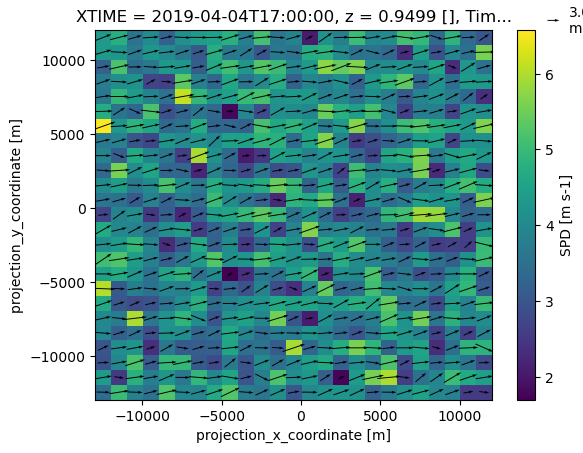

In [20]:
# Now, add the wind speed and make the plot...

ds_xwrf["SPD"] = np.sqrt(ds_xwrf["wind_east"]**2 + ds_xwrf["wind_north"]**2).rename("wind speed").\
                    assign_attrs(units="m s-1", description="wind speed")

ds_xwrf_thinned = ds_xwrf.\
    isel(x=slice(0, nx, skip_xy), y=slice(0, ny, skip_xy), z=plot_level).\
    sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")

fig, ax = plt.subplots(ncols=1)
ds_xwrf_thinned["SPD"].plot(ax=ax, x="x", y="y")
ds_xwrf_thinned.plot.quiver(ax=ax, x="x", y="y", u="wind_east", v="wind_north",
                            scale=100)
plt.show()


That was a LOT less code!

## COGS Cloud Fraction

#### todo: section in development...

The Cloud Optically Gridded by Stereo (COGS) data set is very good for cloud fractions <0.5. How does the the COGS cloud fraction compare to this simulation?

Let's open one of the COGS obs-mod files to see how the hourly data is stored in these files. They contain both the observation and model values on aligned coordinates. Note the "source_type" coordinate's attribute.
* source_type == 0 is the processed observations
* source_type == 1 is the processed model output

In [21]:
# We will use the processed, hourly cloud fraction data from the sgplassocogsdiagobsmod datastream.
ds_cogs = xr.open_dataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/obs_model/sgplassocogsdiagobsmod{sim_id}C1.m1.{case_date:%Y%m%d}.120000.nc")
ds_cogs

<xarray.Dataset> Size: 1kB
Dimensions:                               (time: 16, bound: 2, source_type: 2)
Coordinates:
  * time                                  (time) datetime64[ns] 128B 2019-04-...
  * source_type                           (source_type) int32 8B 0 1
Dimensions without coordinates: bound
Data variables:
    base_time                             datetime64[ns] 8B ...
    time_offset                           (time) datetime64[ns] 128B ...
    time_bounds                           (time, bound) datetime64[ns] 256B ...
    low_cloud_fraction_cogs               (time, source_type) float32 128B ...
    qc_low_cloud_fraction_cogs            (time, source_type) int32 128B ...
    low_cloud_fraction_cogs_goodfraction  (time, source_type) float32 128B ...
    low_cloud_fraction_cogs_std           (time, source_type) float32 128B ...
    lat                                   float32 4B ...
    lon                                   float32 4B ...
    alt                                   float32 4B ...
Attributes: (12/34)
    command_line:                          Not applicable
    Conventions:                           ARM-1.3
    process_version:                       Not applicable
    dod_version:                           lassocogsdiagobsmod4-m1-1.0
    input_datastreams:                     sgplassodiagmod4C1.m1 : 1.1 : 2019...
    site_id:                               sgp
    ...                                    ...
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    doi:                                   10.5439/1673163
    history:                               created by user ttoto on machine a...

Plotting these side-by-side is now easy since everything is aligned and sampled similarly.

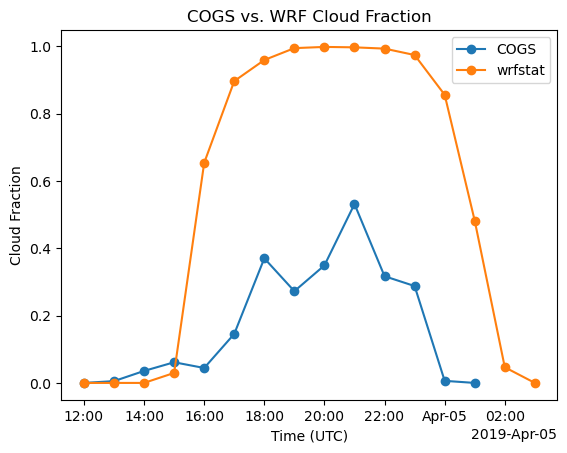

In [22]:
fig, ax = plt.subplots(ncols=1)

# These two lines are all you really need for a quick-and-dirty plot...
ds_cogs["low_cloud_fraction_cogs"].isel(source_type=0).plot(ax=ax, marker="o", label="COGS")
ds_cogs["low_cloud_fraction_cogs"].isel(source_type=1).plot(ax=ax, marker="o", label="wrfstat")

# If you plan to share with frieds, do a little clean-up beyond the default labelling from xarray...
ax.legend()
ax.set_title("COGS vs. WRF Cloud Fraction")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Cloud Fraction")

plt.show()